##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [4]:
!pip install sounddevice
!pip install pydub
!pip install numpy
!pip install tensorflow
!pip install pyaudio
!pip install librosa
!pip install noisereduce
!pip install torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 3.4 MB/s eta 0:00:00:00:0100:01


start recording...
recording stopped


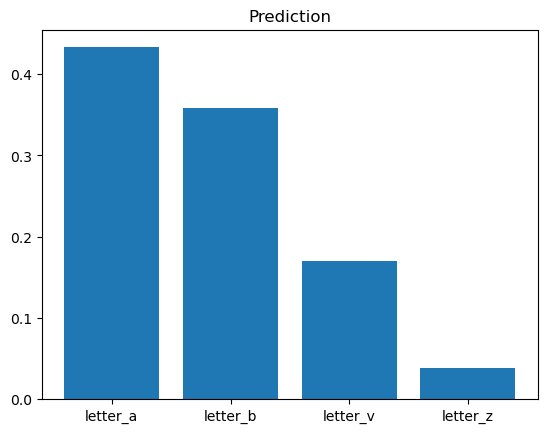

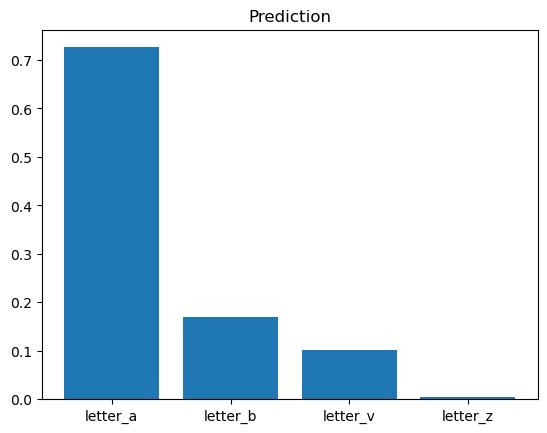

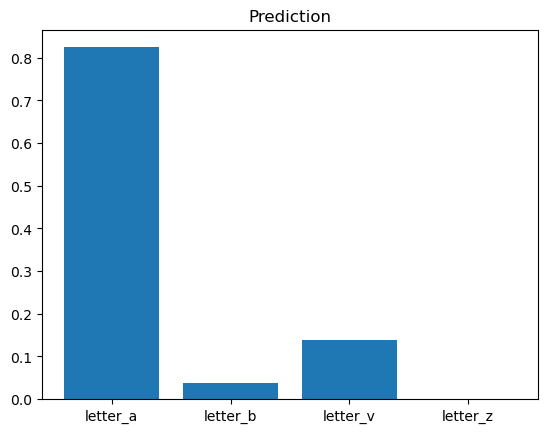

start recording...
recording stopped


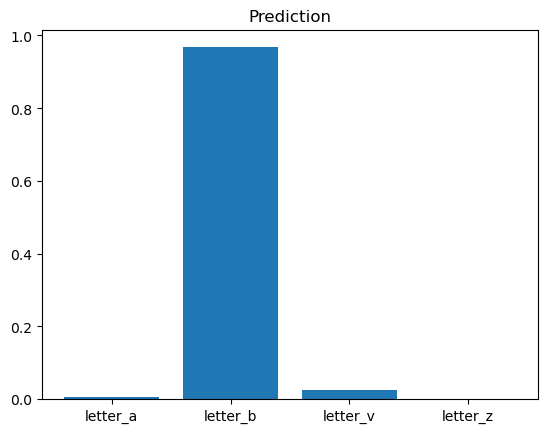

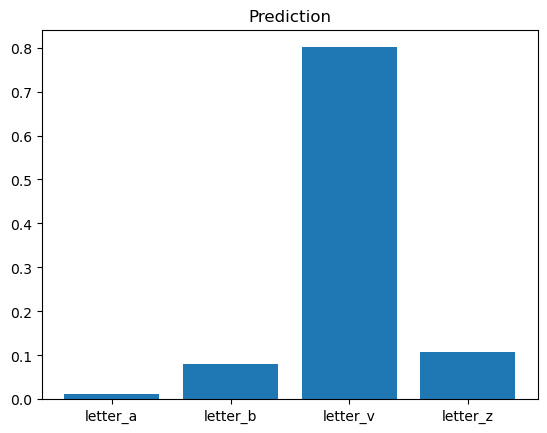

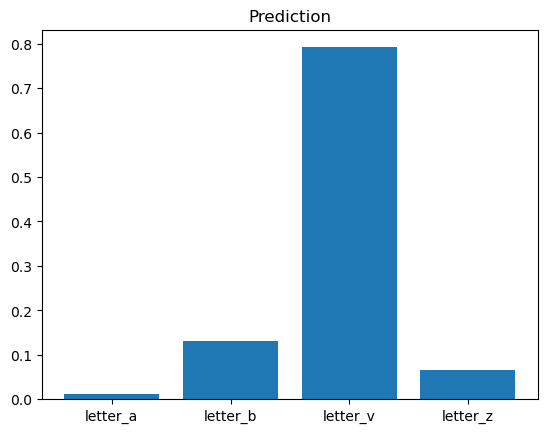

In [ ]:
import tensorflow as tf
import tkinter as tk
import sounddevice as sd
import matplotlib.pyplot as plt
import pyaudio
import datetime
import wave
import numpy as np
import noisereduce as nr

from pydub import AudioSegment
from pydub.silence import split_on_silence

# Define constants for audio recording
FRAMES_PER_BUFFER = 3200
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000

# Initialize PyAudio
p = pyaudio.PyAudio()

audio_data = None

# Define a function to capture audio from the microphone
def record_audio(duration):
    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=RATE,
        input=True,
        frames_per_buffer=FRAMES_PER_BUFFER
    )

    print("start recording...")

    frames = []
    for _ in range(int(RATE * duration / FRAMES_PER_BUFFER)):
        data = stream.read(FRAMES_PER_BUFFER)
        frames.append(data)

    print("recording stopped")

    stream.stop_stream()
    stream.close()

    # Convert the recorded audio frames to a NumPy array with the correct data type
    audio_data = np.frombuffer(b''.join(frames), dtype=np.int16)
    
   
    return audio_data


# Load the TensorFlow SavedModel
loaded_model = tf.saved_model.load('saved_model')

def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

        
# Define a function to preprocess audio data and make predictions
def process_and_predict_audio():
    # Record audio from the microphone for a specified duration
    duration = 5  # Recording duration in seconds
    audio_data = record_audio(duration)

    audio_data = nr.reduce_noise(audio_data, RATE)
   
    # Convert the audio data to bytes
    audio_bytes = audio_data.tobytes()
    
    audio_segment = AudioSegment(data=audio_bytes, sample_width=2, frame_rate=RATE, channels=1)
    
    # Define silence threshold and minimum silence duration
    silence_threshold = -60  # Adjust according to your audio
    min_silence_duration = 50  # Adjust according to your audio

    # Split the audio into chunks based on silence
    chunks = split_on_silence(audio_segment, min_silence_duration, silence_threshold)

    for chunk in chunks:
        audio_array = np.array(chunk.get_array_of_samples())

        # Preprocess the audio data
        waveform = tf.convert_to_tensor(audio_array, dtype=tf.float32)
        waveform /= tf.int16.max  # Normalize the waveform
        spectrogram = get_spectrogram(waveform)

        spectrogram = tf.image.resize(spectrogram, (45, 129))
        spectrogram = spectrogram[tf.newaxis, ...]  # Add batch dimension

        #sd.play(audio_array, samplerate=RATE)

        # Make prediction using the loaded model
        prediction = loaded_model(spectrogram)


        x_labels = ['letter_a', 'letter_b', 'letter_v', 'letter_z']
        plt.bar(x_labels, tf.nn.softmax(prediction[0]))
        plt.title('Prediction')
        plt.show()

# Define a function to replay recorded audio
def replay_audio(audio_data):
    if 'audio_data':
        sd.play(audio_data, samplerate=RATE)
    else:
        print('no audio')
        
# Create the main application window
root = tk.Tk()
root.title("Microphone Recorder")

# Create a button to record and process audio
record_button = tk.Button(root, text="Record and Predict", command=process_and_predict_audio)
record_button.pack(pady=10)


# Run the GUI
root.mainloop()
